# Algorithmic Fairness

In [ ]:
import numpy as np

In [2]:
import numpy as np
#if not yet installed execute
#!conda install powerai::aif360==0.6.1 -y
from aif360.algorithms.preprocessing import Reweighing

# !!Attention: On first execution this will produce an warning 
# but should work if you just execute it again.

In [3]:
# load German credit dataset
from aif360.datasets import GermanDataset

In [ ]:
# load German credit dataset
from aif360.datasets import GermanDataset

# --->>> Attention <<<---
# !!Attention: On first execution this will produce an error which tells you 
# where you should copy the german.data file!!
# you finde the files german.data and german.doc also on moodle

dataset_orig = GermanDataset(
    protected_attribute_names=['age'],           
    privileged_classes=[lambda x: x >= 25],     # age >=25 is considered privileged
    features_to_drop=['personal_status', 'sex'] 
)

# train test split
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}]

In [9]:
# Calculate the difference in mean outcomes between unprivileged and privileged groups
from aif360.metrics import BinaryLabelDatasetMetric

metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

metric_orig_train.mean_difference()

-0.14207489015673158

In [4]:
# Meaning: The privileged group is getting 15% more positive outcomes
# than the unprivileged group

## Mitigate bias by transforming the original dataset

In [5]:
# We are going to mitigate this bias in the training dataset
# by applying the Reweighing algorithm from the paper:
# F. Kamiran and T. Calders, "Data Preprocessing Techniques for Classification without Discrimination," Knowledge and Information Systems, 2012.

In [9]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(dataset_orig_train)

In [10]:
# Check the bias of the transformed dataset
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)
"%.3f" % metric_transf_train.mean_difference()

'-0.000'

In [8]:
# Thus, the bias has been removed :-)

In [9]:
# A possible next step would be to check how the transformed dataset impacts
# the accuracy and fairness of a trained model.
# see e.g. https://github.com/Trusted-AI/AIF360/blob/main/examples/demo_reweighing_preproc.ipynb 

## Evaluation of logistic regression on original dataset

We evaluate the fairness here by measuring abs(1 - disparate impact).
$$ \text{disparate impact} = \frac{\text{selection rate for unprivileged group​}}{\text{selection rate for privileged group​}}$$
A value of 1 means there is no disparity, thus abs(1 - disparate impact) would be 0. 
The 80% rule (common in U.S. law) considers a disparate impact of less than 0.8 (i.e. abs(1 - disparate impact) of more than 0.2) as evidence of potential discrimination.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from aif360.metrics import ClassificationMetric
from matplotlib import pyplot as plt

# Logistic regression classifier and predictions
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
w_train = dataset_orig_train.instance_weights.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train, 
         sample_weight=w_train)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

In [12]:
dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [13]:
# Find the optimal classification threshold from the validation set
num_thresh = 100
ba_arr = np.zeros(num_thresh)
di_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_test_pred.scores > class_thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    classified_metric_orig_test = ClassificationMetric(dataset_orig_test,
                                             dataset_orig_test_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_test.true_positive_rate()
                       +classified_metric_orig_test.true_negative_rate())
    di_arr[idx] = classified_metric_orig_test.disparate_impact()

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]
best_di = di_arr[best_ind]

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)
print("disparate impact at best balanced accuracy (with reweighting) = %.4f" % best_di)
#abs(1-disparate impact) must be small (close to 0) for classifier predictions to be fair.

Best balanced accuracy (no reweighing) = 0.7328
Optimal classification threshold (no reweighing) = 0.6039
disparate impact at best balanced accuracy (with reweighting) = 0.5811


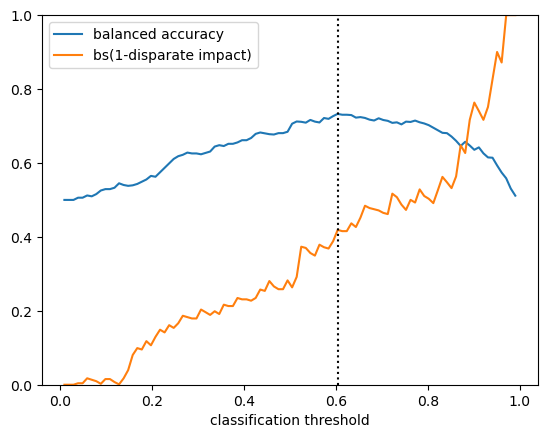

In [14]:
plt.plot(class_thresh_arr,ba_arr,label='balanced accuracy')
plt.plot(class_thresh_arr,np.abs(1-di_arr),label='bs(1-disparate impact)')
plt.ylim([0,1])
plt.vlines(x=best_class_thresh,ymin=0,ymax=1,colors='black',linestyle='dotted')
plt.xlabel("classification threshold")
plt.legend()

## Evaluation of logistic regression on reweighted dataset

In [15]:
scale_transf = StandardScaler()
X_train = scale_transf.fit_transform(dataset_transf_train.features)
y_train = dataset_transf_train.labels.ravel()
w_train = dataset_transf_train.instance_weights.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train,
        sample_weight=w_train)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_transf_train.favorable_label)[0][0]

dataset_transf_train_pred = dataset_transf_train.copy()
dataset_transf_train_pred.labels = y_train_pred

In [16]:
dataset_transf_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_transf.fit_transform(dataset_transf_test_pred.features)
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [17]:
# Find the optimal classification threshold from the validation set
num_thresh = 100
ba_arr = np.zeros(num_thresh)
di_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_transf_test_pred.scores > class_thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    classified_metric_transf_test = ClassificationMetric(dataset_orig_test,
                                             dataset_transf_test_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_transf_test.true_positive_rate()
                       +classified_metric_transf_test.true_negative_rate())
    di_arr[idx] = classified_metric_transf_test.disparate_impact()

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]
best_di = di_arr[best_ind]

print("Best balanced accuracy (with reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (with reweighing) = %.4f" % best_class_thresh)
print("abs(1-disparate impact) at best balanced accuracy (with reweighting) = %.4f" % np.abs(1-best_di))
#abs(1-disparate impact) must be small (close to 0) for classifier predictions to be fair.

Best balanced accuracy (with reweighing) = 0.7225
Optimal classification threshold (with reweighing) = 0.7524
abs(1-disparate impact) at best balanced accuracy (with reweighting) = 0.3510


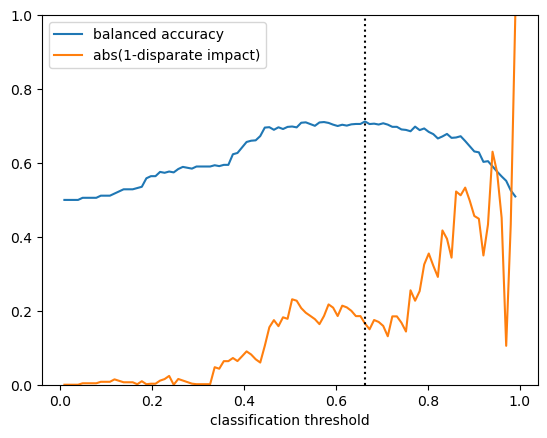

In [17]:
plt.plot(class_thresh_arr,ba_arr,label='balanced accuracy')
plt.plot(class_thresh_arr,np.abs(1-di_arr),label='abs(1-disparate impact)')
plt.ylim([0,1])
plt.vlines(x=best_class_thresh,ymin=0,ymax=1,colors='black',linestyle='dotted')
plt.xlabel("classification threshold")
plt.legend()

In [ ]:
# we see that abs(1 - disparate impact) has gone down at the optimal threshold from 0.4 to 0.2. 